In [1]:
# %% import libs
# init
import importlib
import pickle
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from geopy.distance import geodesic
from statsmodels.distributions.empirical_distribution import ECDF
from tqdm import trange
from matplotlib.lines import Line2D
import os
import cartopy.crs as ccrs

from cartopy.mpl.ticker import (
    LatitudeFormatter,
    LatitudeLocator,
    LongitudeFormatter,
    LongitudeLocator,
)
# Custom
import mstme.mstmeclass as mc
from mstme.mstmeclass import STM
style_path = Path("./src/plot_style.txt")
plt.style.use(style_path)
pos_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
rng = np.random.default_rng(seed=1000)

G = mc.G
G_F = mc.G_F




ModuleNotFoundError: No module named 'mstme'

In [2]:
region = "caribbean"
depth = -100

match region:
    case "guadeloupe":
        dir_data = "./data/ww3_meteo_max/*.nc"
        dir_bathy = "./data/Bathy.nc"
        min_lon = -62.00
        min_lat = 15.80
        max_lon = -60.80
        max_lat = 16.60
        dir_tracks = "./data/tracks"
        occur_freq = 44 / (2021 - 1971 + 1)
    # the cyclones were selected as passing at distance of 200km from Guadeloupe.
    # According to IBTrACS, there were 44 storms of class 0~5 during 1971-2021
    case "caribbean":
        dir_data = "./data/ww3_meteo_max/*.nc"
        dir_bathy = "./data/Bathy.nc"
        min_lon = -65.00
        min_lat = 12.00
        max_lon = -58.00
        max_lat = 18.00
        dir_tracks = "./data/tracks"
        occur_freq = 44 / (2021 - 1971 + 1)
    # the cyclones were selected as passing at distance of 200km from Guadeloupe.
    # According to IBTrACS, there were 44 storms of class 0~5 during 1971-2021
    # case "reunion":
    #     dir_data = "./reunion_data/*.nc"
    #     min_lon = -180
    #     min_lat = -180
    #     max_lon = 180
    #     max_lat = 180
    #     occur_freq = 53 / (2021 - 1971 + 1)
    #     dir_tracks = None
    #     dir_bathy = None
    # Jeremy:
    # Acccording to the IBTrACS databse, there are 53 cyclones over the time period 1971-2021 within an area defined by radius of 400 km from the Island center.
    case _:
        min_lon = None
        min_lat = None
        max_lon = None
        max_lat = None
        dir_tracks = None
        occur_freq = None
        dir_bathy = None
        raise (ValueError(f"No region found with name {region}"))

ds_path = Path(f"./data/ds_filtered_{region}.pickle")
ds_track_path = Path(f"./data/ds_track_{region}.pickle")
if ds_path.exists():
    with open(ds_path, "rb") as f:
        ds_filtered: xr.Dataset = pickle.load(f)
else:
    ds_full = xr.open_mfdataset(
        dir_data,
        combine="nested",
        concat_dim="event",
        parallel=True,
        engine="netcdf4",
    )
    ds_bathy_full = xr.open_dataset(dir_bathy, engine="netcdf4")
    ds_filtered = xr.merge([ds_full, ds_bathy_full], compat="override").compute()
    ds_filtered = (
        ds_filtered.drop_dims(("single", "nele"))
        .where(lambda x: x.longitude >= min_lon, drop=True)
        .where(lambda x: x.longitude <= max_lon, drop=True)
        .where(lambda x: x.latitude >= min_lat, drop=True)
        .where(lambda x: x.latitude <= max_lat, drop=True)
        .where(lambda x: x.bathymetry < depth, drop=True)
        .compute()
    )
    da_category = pd.read_csv('./data/category.csv',header=None,index_col=None,names=['Category']).to_xarray().drop_vars('index').rename_dims({'index':'event'})['Category']
    ds_filtered['Category'] = da_category
    _tracks_all = []
    Radius = []
    Timestamps = []
    Vfm = []
    U10_max = []
    XbyRd = []
    max_len = 0
    
    for ei, tp in enumerate(Path(dir_tracks).glob("*.txt")):
        _df = pd.read_csv(tp, delimiter="\t")
        # get time step
        tdelta = datetime.strptime(
            _df["time"].iloc[1], "%Y-%m-%d %H:%M:%S"
        ) - datetime.strptime(_df["time"].iloc[0], "%Y-%m-%d %H:%M:%S")
        dt = tdelta.total_seconds()

        _track = _df[["latitude", "longitude"]].to_numpy()
        _idx_U10_is_max: int = int(_df["U10_max"].idxmax())
        _prev = _track[_idx_U10_is_max - 1]
        _next = _track[_idx_U10_is_max + 1]
        _dist = geodesic(_prev, _next).m / 2
        _vfm = _dist / dt
        _radius = _df["Radius"].iloc[_idx_U10_is_max] * 1e3
        _u10_max = _df["U10_max"].iloc[_idx_U10_is_max]
        Vfm.append(_vfm)
        Radius.append(_radius)
        U10_max.append(_u10_max)
        Timestamps.append(_df["time"])
        max_len = max(max_len, len(_track))
        _tracks_all.append(_track)
    for i, t in enumerate(_tracks_all):
        _tracks_all[i] = np.pad(
            _tracks_all[i],
            ((0, max_len), (0, 0)),
            mode="constant",
            constant_values=np.array([np.nan, np.nan]),
        )[:max_len]
    tracks_all = np.array(_tracks_all)
    Radius = np.array(Radius)
    U10_max = np.array(U10_max)
    Vfm = np.array(Vfm)

    ds_filtered["Radius"] = xr.DataArray(Radius, dims="event")
    ds_filtered["V_max"] = xr.DataArray(U10_max * G_F, dims="event")
    ds_filtered["Vfm"] = xr.DataArray(Vfm, dims="event")
    ds_filtered["Tracks"] = xr.DataArray(tracks_all, dims=("event", "time", "latlon"))
    for v in STM:
        ds_filtered[f"STM_{v.key()}"] = ds_filtered[v.key()].max(dim="node")
        ds_filtered[f"EXP_{v.key()}"] = (
            ds_filtered[v.key()] / ds_filtered[f"STM_{v.key()}"]
        )
    print(ds_filtered)

    # pickle Dataset
    with open(f"./data/ds_filtered_{region}.pickle", "wb") as fh:
        pickle.dump(ds_filtered, fh)
ds = ds_filtered

num_events=ds.dims['event']

c:\Users\Kosuke\miniforge3\envs\mstme\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [3]:
a = np.array([[1,2,3],[4,5,6]]) #num_pos, num_ss
b= np.array([[1],[1]]) #num_pos
a-b

array([[0, 1, 2],
       [3, 4, 5]])

# Output directory

In [4]:
dir_out = Path('./output-new/common/')

# TC tracks and their category

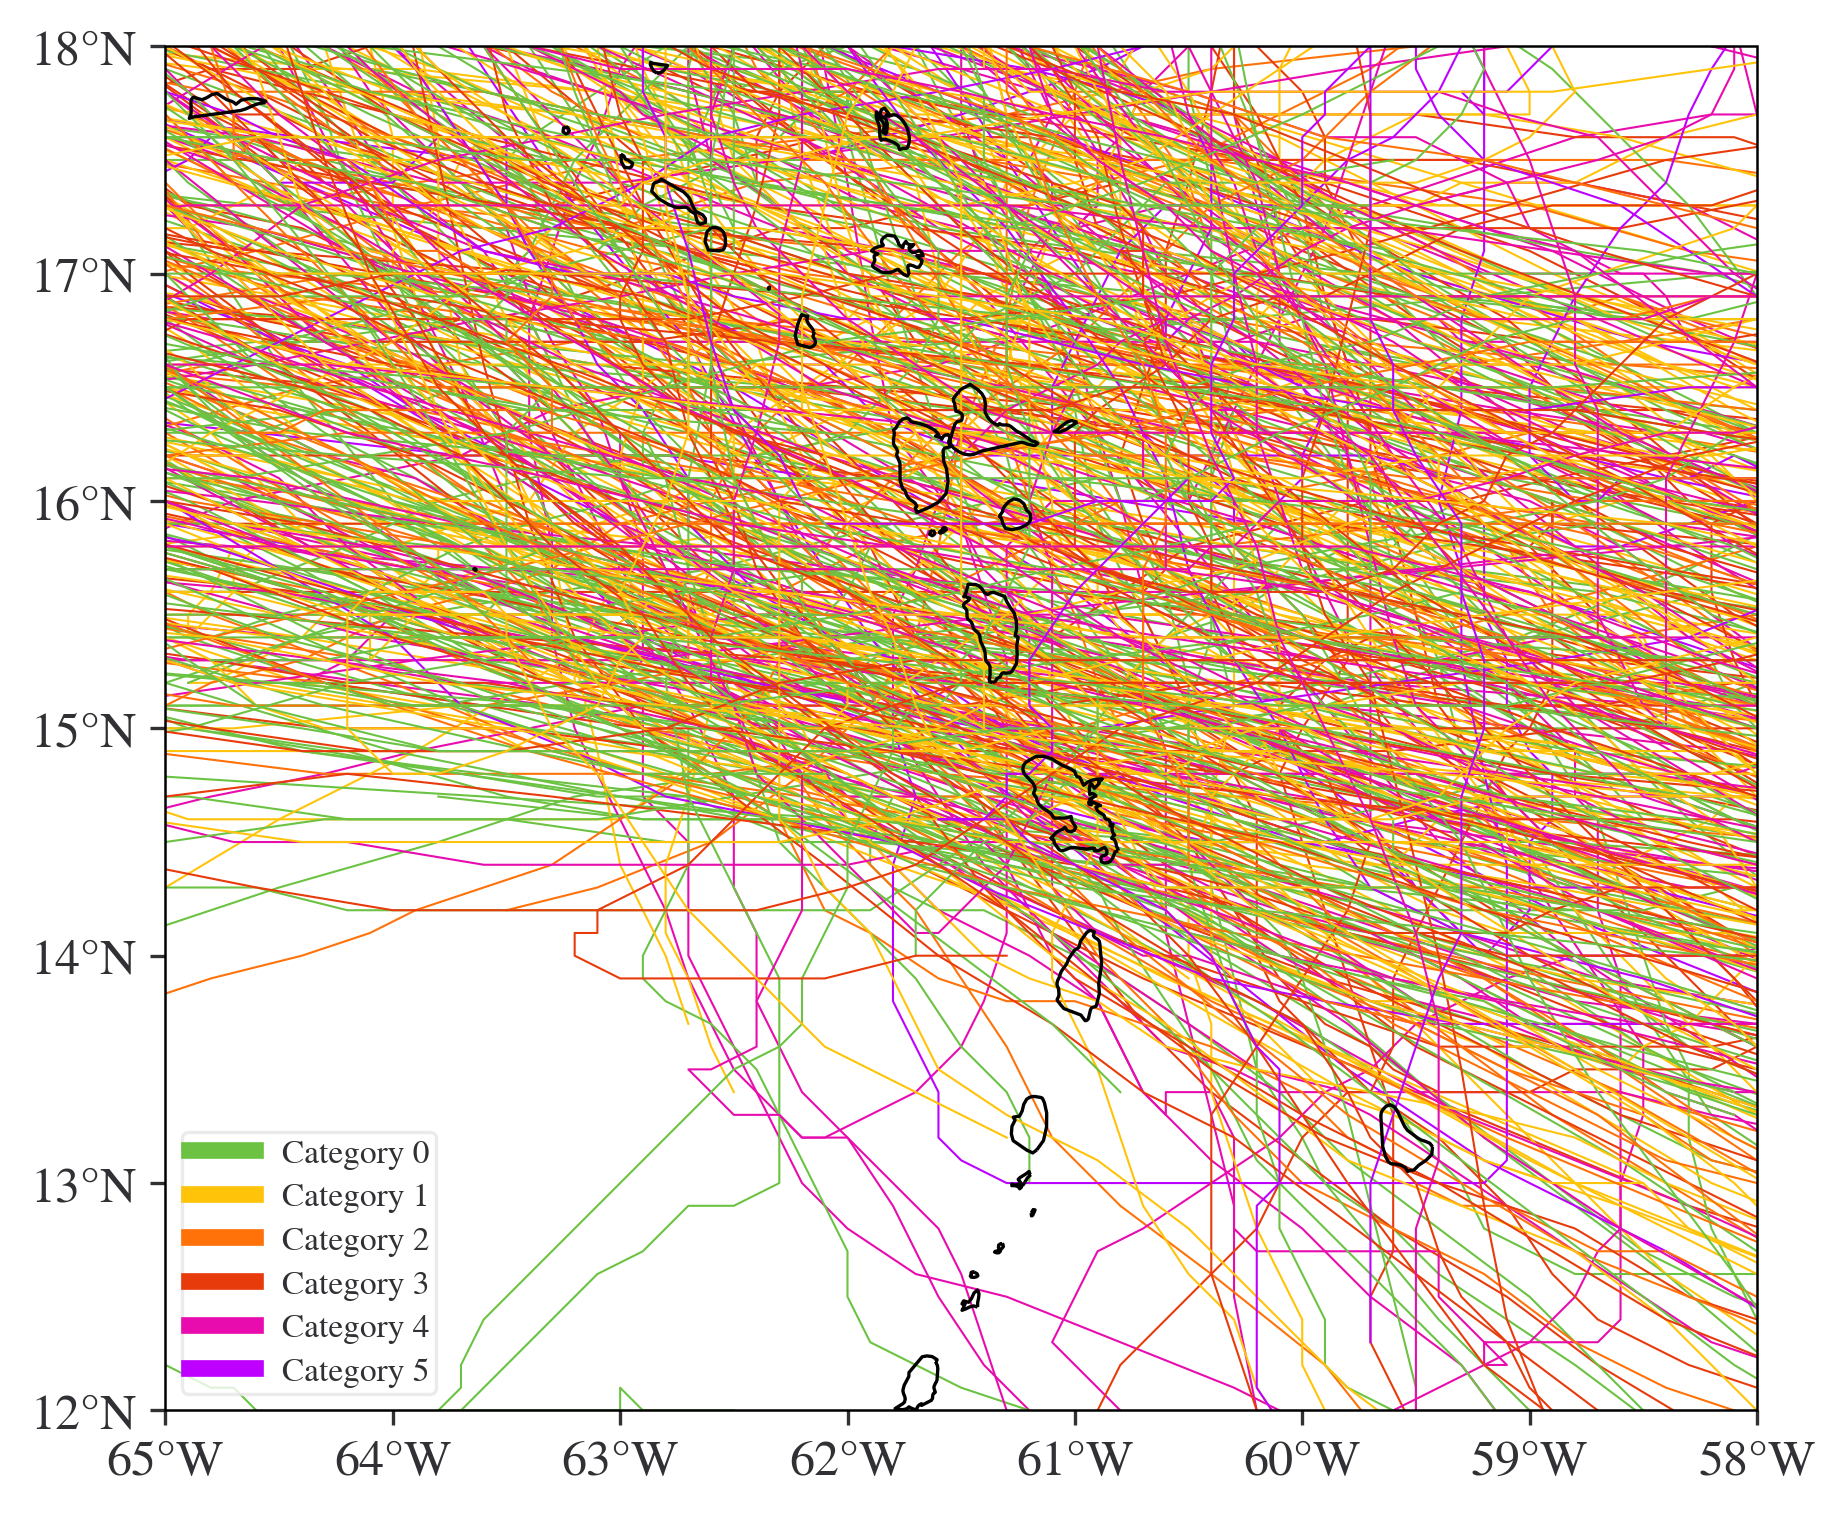

In [11]:
def create_custom_ticks(vmin, vmax, tick):
    ticks = []
    assert vmin < vmax
    start = (vmin + tick) // tick * tick
    end = -(vmax // -tick) * tick
    return [vmin] + list(np.arange(start, end, tick)) + [vmax]

cm = 1/2.54
fig, ax = plt.subplots(
    1,
    1,
    facecolor="white",
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(18*cm,15*cm),
)
color_list = ['green', 'yellow', 'orange', 'red', 'magenta', 'purple']
color_list = ['#6cc343', '#ffc309', '#ff7209', '#e83b0c', '#e80cae', '#bd00ff']
alpha_list = [0.1, 0.2, 0.3, 0.5, 0.7, 1]
ax.set_ylim(min_lat,max_lat)
ax.set_xlim(min_lon,max_lon)
ax.set_xticks(create_custom_ticks(min_lon,max_lon,1.0),crs=ccrs.PlateCarree())
ax.set_yticks(create_custom_ticks(min_lat,max_lat,1.0),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# ax.xaxis.set_major_locator(LongitudeLocator(dms=True))
# ax.yaxis.set_major_locator(LatitudeLocator(dms=True))
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)
for ei in range(num_events):
    ax.plot(
        ds["Tracks"].isel(event=ei)[:,1],
        ds["Tracks"].isel(event=ei)[:,0],
        c=color_list[ds['Category'].isel(event=ei).data],
        # alpha=alpha_list[ds['Category'].isel(event=ei).data],
        lw=0.5,
        zorder=-10,
    )
custom_lines = [Line2D([0], [0], 
                       color=color_list[i],
                    #    alpha=alpha_list[i],
                       lw=4)
                         for i in range(len(color_list))]
ax.legend(custom_lines,[f'Category {i:d}' for i in range(len(color_list))],prop={'size':8})
ax.coastlines()
file_name = 'TC_tracks_vs_category_guadeloupe'
plt.savefig(f"{dir_out}/{file_name}.pdf", bbox_inches="tight")
plt.savefig(f"{dir_out}/{file_name}.png", bbox_inches="tight")

(0.0, 1.0)

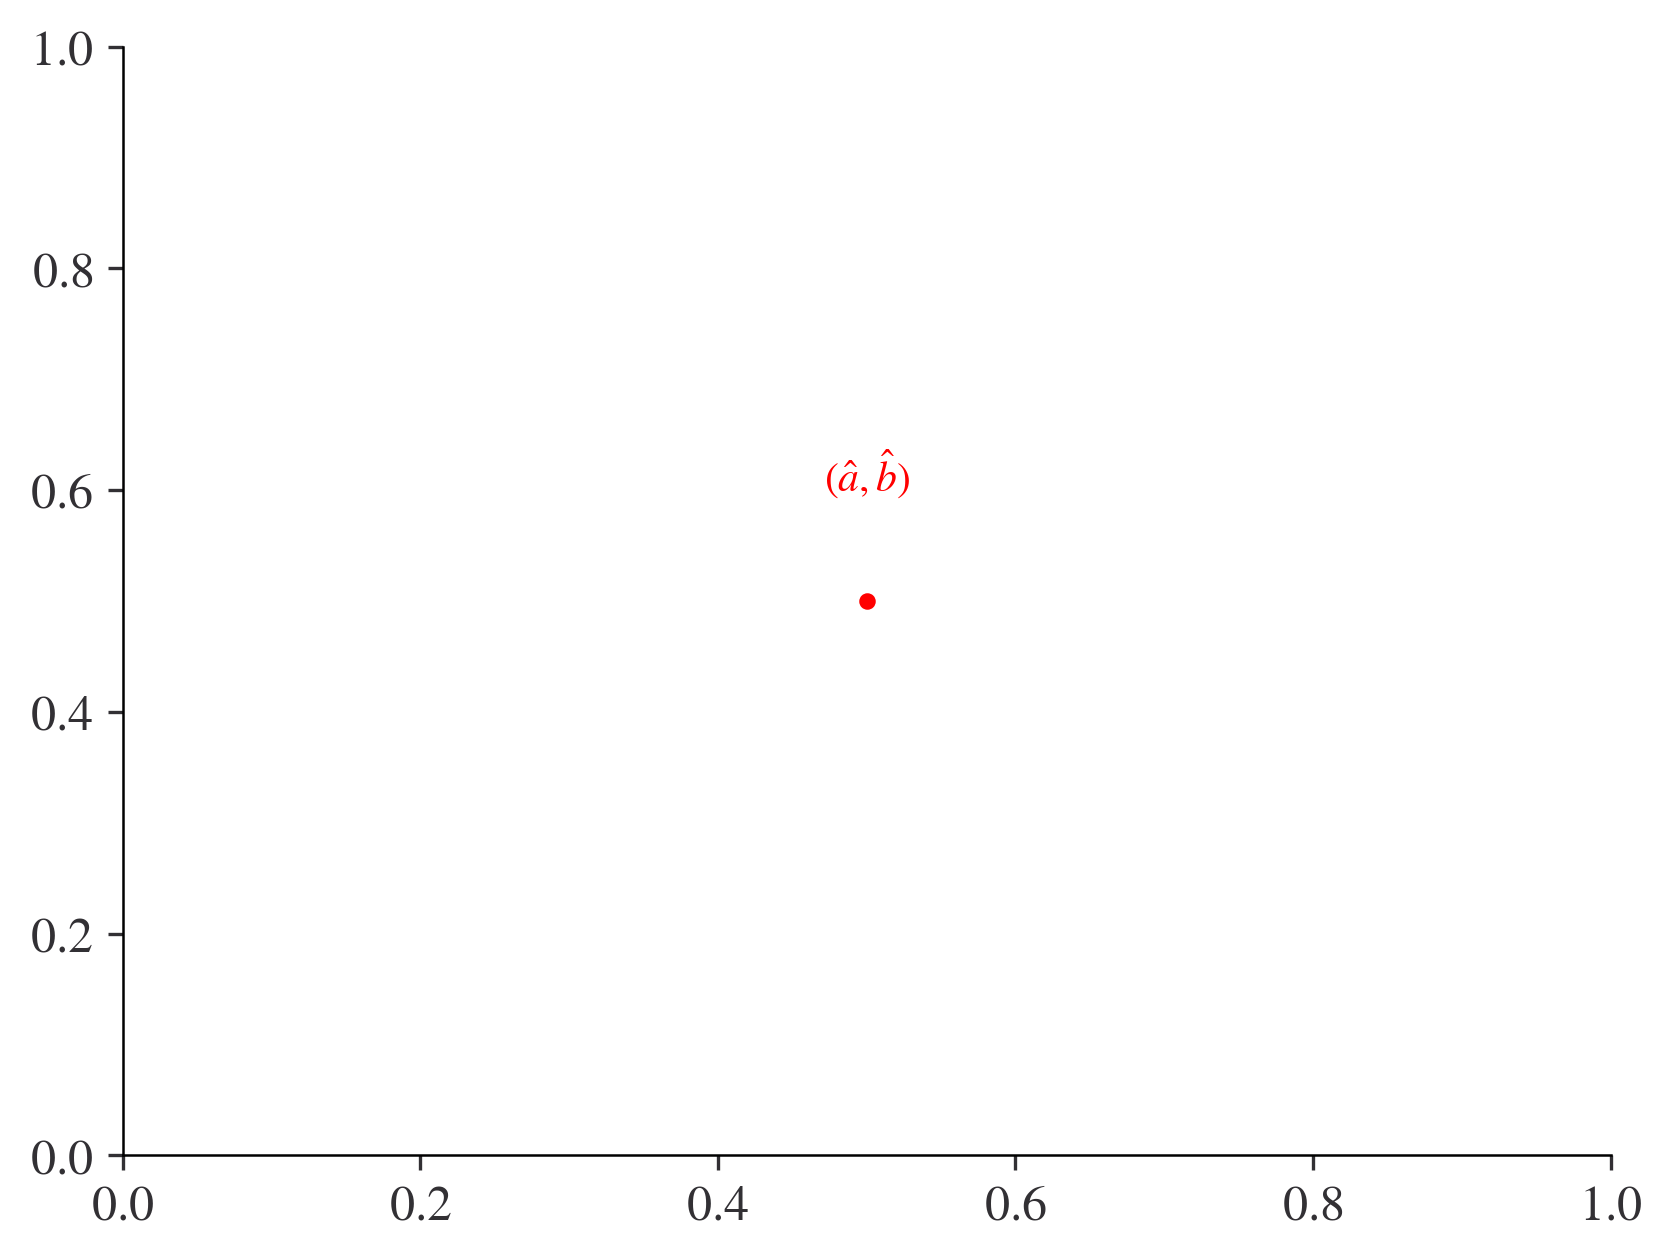

In [86]:
plt.scatter(
    0.5,
    0.5,
    c="red",
    s=10,
)
plt.text(
    0.5,
    0.5 + 0.1,
    f"$(\hat a, \hat b)$",
    ha="center",
    c="red",
)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [50]:
import numpy as np

In [73]:
def create_custom_ticks(vmin,vmax,tick):
    ticks = []
    assert vmin < vmax
    start = (vmin+tick)//tick*tick
    end = -(vmax//-tick)*tick
    return [vmin]+list(np.arange(start,end,tick))+[vmax]